# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://docs.langchain.com/oss/python/concepts/memory#profile) or [collection](https://docs.langchain.com/oss/python/concepts/memory#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to pull together the pieces we've learned to build an agent with long-term memory.

Our agent, `task_mAIstro`, will help us manage a ToDo list! 

The chatbots we built previously *always* reflected on the conversation and saved memories. 

`task_mAIstro` will decide *when* to save memories (items to our ToDo list).

The chatbots we built previously always saved one type of memory, a profile or a collection. 

`task_mAIstro` can decide to save to either a user profile or a collection of ToDo items.

In addition semantic memory, `task_mAIstro` also will manage procedural memory.

This allows the user to update their preferences for creating ToDo items. 

In [19]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [41]:
import uuid
from pprint import pprint
from helper import *
from pydantic import BaseModel, Field
from trustcall import create_extractor
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, merge_message_runs
from typing import TypedDict, Literal, Optional, List
from IPython.display import Image, display
from datetime import datetime
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

In [3]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [4]:
_set_env("OPENAI_API_KEY")

## Visibility into Trustcall updates

Trustcall creates and updates JSON schemas.

What if we want visibility into the *specific changes* made by Trustcall?

For example, we saw before that Trustcall has some of its own tools to:

* Self-correct from validation failures -- [see trace example here](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7) 
* Update existing documents -- [see trace example here](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

Visibility into these tools can be useful for the agent we're going to build.

Below, we'll show how to do this!

In [5]:
class Memory(BaseModel):
    content: str = Field(
        description="The main content of the memory. For example: User expressed interest in learning about French."
    )

class MemoryCollection(BaseModel):
    memories: List[Memory] = Field(
        description="A list of memories about the user."
    )

We can add a [listener](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners) <!-- broken, but cannot find better linke --> to the Trustcall extractor.

This will pass runs from the extractor's execution to a class, `Spy`, that we will define.

Our `Spy` class will extract information about what tool calls were made by Trustcall.

In [6]:
# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

In [7]:
# Initialize the spy
spy = Spy()

In [8]:
# Initialize the model
model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
model.invoke("Hello").content

'Hello! How can I assist you today?'

In [9]:
# Create the extractor
trustcall_extractor = create_extractor(
    llm=model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [10]:
# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [11]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_jeUzouAFUjrB5CL4H0XD0SPG)
 Call ID: call_jeUzouAFUjrB5CL4H0XD0SPG
  Args:
    content: User had a nice bike ride in San Francisco this morning.


In [12]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='User had a nice bike ride in San Francisco this morning.'


In [13]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_jeUzouAFUjrB5CL4H0XD0SPG'}


In [14]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'User had a nice bike ride in San Francisco this morning.'})]

In [15]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})

In [16]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_Gk7si4MeZap57nGc87889BN6', 'json_doc_id': '0'}
{'id': 'call_sbaOFP4C3ji16IEMCutOpHfD'}
{'id': 'call_35g6rLMas4RyqPwPqFnkveOW'}


In [17]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_Gk7si4MeZap57nGc87889BN6)
 Call ID: call_Gk7si4MeZap57nGc87889BN6
  Args:
    content: User went to Tartine and ate a croissant.
    -: {'content': 'User is thinking about going back to Japan this winter.'}
  Memory (call_sbaOFP4C3ji16IEMCutOpHfD)
 Call ID: call_sbaOFP4C3ji16IEMCutOpHfD
  Args:
    content: User went to Tartine and ate a croissant.
  Memory (call_35g6rLMas4RyqPwPqFnkveOW)
 Call ID: call_35g6rLMas4RyqPwPqFnkveOW
  Args:
    content: User is thinking about going back to Japan this winter.


In [18]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='User went to Tartine and ate a croissant.'
content='User went to Tartine and ate a croissant.'
content='User is thinking about going back to Japan this winter.'


In [19]:
spy.called_tools

[[{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': '1. Replace the existing content with a new memory about visiting Tartine and eating a croissant. 2. Add a new memory about planning to go back to Japan this winter.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'User went to Tartine and ate a croissant.'},
     {'op': 'add',
      'path': '/-',
      'value': {'content': 'User is thinking about going back to Japan this winter.'}}]},
   'id': 'call_Gk7si4MeZap57nGc87889BN6',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'User went to Tartine and ate a croissant.'},
   'id': 'call_sbaOFP4C3ji16IEMCutOpHfD',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'User is thinking about going back to Japan this winter.'},
   'id': 'call_35g6rLMas4RyqPwPqFnkveOW',
   'type': 'tool_call'}]]

In [35]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

In [36]:
# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

Document 0 updated:
Plan: 1. Replace the existing content with a new memory about visiting Tartine and eating a croissant. 2. Add a new memory about planning to go back to Japan this winter.
Added content: User went to Tartine and ate a croissant.

New Memory created:
Content: {'content': 'User went to Tartine and ate a croissant.'}

New Memory created:
Content: {'content': 'User is thinking about going back to Japan this winter.'}


## Creating an agent

There are many different agent architectures to choose from.

Here, we'll implement something simple, a [ReAct](https://docs.langchain.com/oss/python/langgraph/workflows-agents#agents) agent.

This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory: 

(a) Create or update a user `profile` with general user information 

(b) Add or update items in a ToDo list `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

In [37]:
# Update memory tool
class UpdateMemoryTool(BaseModel):
    """ Decision on what memory type to update """

    update_type: Literal["user", "todo", "instructions"]

In [49]:
# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    
    name: Optional[str] = Field(
        description="The name of the user", default=None
    )
    location: Optional[str] = Field(
        description="The user's location", default=None
    )
    job: Optional[str] = Field(
        description="The user's job", default=None
    )
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers", default=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", default_factory=list
    )

# ToDo schema
class ToDo(BaseModel):
    """This is the to do list of the user"""
    
    tasks: List[str] = Field(
        description="The tasks that the user has to do", default=list
    )
    time_to_complete: Optional[int] = Field(
        description="Estimated time to complete the tasks (minutes)", default=None
    )
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)", default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_length=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

## Graph definition 

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

In [50]:
# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    llm=model,
    tools=[Profile],
    tool_choice="Profile"
)

/home/muhammadumerkhan/Gen-Agentic-AI-Tutorials/.venv/lib/python3.12/site-packages/pydantic/json_schema.py:2448: PydanticJsonSchemaWarning: Default value <class 'list'> is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [51]:
def mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):
    pass

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    pass

def update_todo(state: MessagesState, config: RunnableConfig, store: BaseStore):
    pass

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):
    pass

In [53]:
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:
    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    
    messages = state["messages"][-1]
    
    if len(messages.tool_calls) == 0:
        return END

    else:
        tool_call = messages.tool_calls[0]
        if tool_call['args']['update_type'] == 'todo':
            return "update_todos"
        elif tool_call['args']['update_type'] == 'instructions':
            return "update_instructions"
        elif tool_call['args']['update_type'] == 'user':
            return "update_profile"
        else:
            raise ValueError(f"Unknown update type: {tool_call['args']['update_type']}")


In [56]:
# define graph
graph = StateGraph(MessagesState)

# add graph nodes
graph.add_node("mAIstro", mAIstro)
graph.add_node("update_todos", update_todo)
graph.add_node("update_profile", update_profile)
graph.add_node("update_instructions", update_instructions)

# add edges
graph.add_edge(START, "mAIstro")
graph.add_conditional_edges("mAIstro", route_message)
graph.add_edge("update_todos", "mAIstro")
graph.add_edge("update_profile", "mAIstro")
graph.add_edge("update_instructions", "mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
workflow = graph.compile(checkpointer=within_thread_memory, store=across_thread_memory)

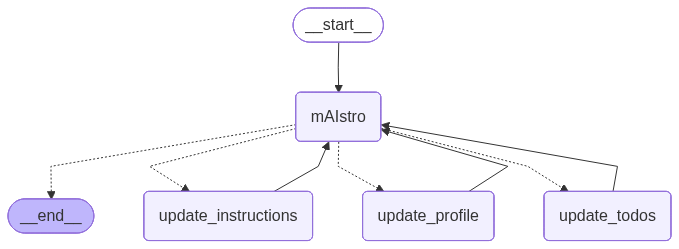

In [58]:
display(Image(workflow.get_graph(xray=1).draw_mermaid_png()))

We can see that Trustcall performs patching of the existing memory:

https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r

Now we can create a new thread.

This creates a new session. 

Profile, ToDos, and Instructions saved to long-term memory are accessed. 

Trace: 

https://smith.langchain.com/public/84768705-be91-43e4-8a6f-f9d3cee93782/r

## Studio

![Screenshot 2024-11-04 at 1.00.19 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732cfb05d9709862eba4e6c_Screenshot%202024-11-11%20at%207.46.40%E2%80%AFPM.png)